1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
    - ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
    - CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?
    - CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

CAM을 얻기 위한 기본모델을 구성하고 학습을 진행한 다음 Loss와 Accuracy를 분석하여 학습이 안정적으로 수렴하였는지 확인해보자.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import os

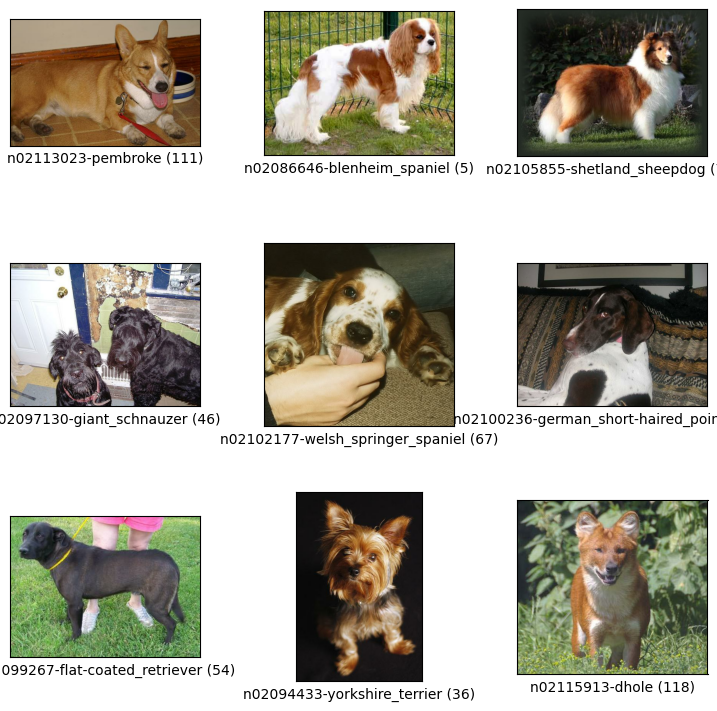

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

tfds.show_examples(ds_train, ds_info)
ds_info.features

In [3]:
num_classes = ds_info.features['label'].num_classes
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)
x = model.output
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs=model.input, outputs=preds)
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [4]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test, is_test=True)

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [6]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [7]:
EPOCH = 20
BATCH_SIZE = 64

In [8]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
187/187 [==============================] - 33s 128ms/step - loss: 3.6829 - accuracy: 0.1932 - val_loss: 5.1467 - val_accuracy: 0.0084
Epoch 2/20
187/187 [==============================] - 24s 126ms/step - loss: 2.1086 - accuracy: 0.4328 - val_loss: 4.9501 - val_accuracy: 0.0084
Epoch 3/20
187/187 [==============================] - 24s 129ms/step - loss: 1.7170 - accuracy: 0.5204 - val_loss: 4.9219 - val_accuracy: 0.0154
Epoch 4/20
187/187 [==============================] - 59s 317ms/step - loss: 1.3043 - accuracy: 0.6337 - val_loss: 3.4587 - val_accuracy: 0.2094
Epoch 5/20
187/187 [==============================] - 35s 186ms/step - loss: 0.9876 - accuracy: 0.7233 - val_loss: 1.8734 - val_accuracy: 0.5019
Epoch 6/20
187/187 [==============================] - 34s 182ms/step - loss: 0.8024 - accuracy: 0.7811 - val_loss: 1.2883 - val_accuracy: 0.6245
Epoch 7/20
187/187 [==============================] - 31s 166ms/step - loss: 0.6869 - accuracy: 0.8092 - val_loss: 1.3170 - val_ac

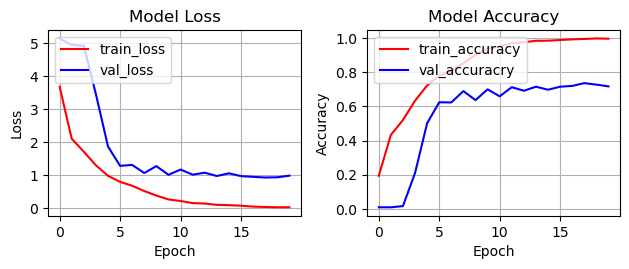

train_loss: 0.035200413316488266 val_loss: 0.9910933375358582
train_accuracy: 0.9976603984832764 val_accuracy: 0.7178171873092651


In [9]:
plt.subplot(2, 2, 1)
plt.plot(history_cam_model.history['loss'], 'r')
plt.plot(history_cam_model.history['val_loss'], 'b')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history_cam_model.history['accuracy'], 'r')
plt.plot(history_cam_model.history['val_accuracy'], 'b')
plt.legend(['train_accuracy', 'val_accuracry'], loc='upper left')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()

print('train_loss:', history_cam_model.history['loss'][-1], 'val_loss:', history_cam_model.history['val_loss'][-1])
print('train_accuracy:', history_cam_model.history['accuracy'][-1], 'val_accuracy:', history_cam_model.history['val_accuracy'][-1])

위와 같이 Loss와 Accuracy가 안정적으로 수렴하였음을 확인할 수 있다.
이제 이 모델에 CAM을 적용하여 모델이 데이터의 클래스를 예측할 때 중점적으로 보는 부분을 확인해보자.

In [10]:
cam_model_path = os.path.abspath('.//Class_Activation_Map')
cam_model.save_weights('cam_model.h5')

In [11]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

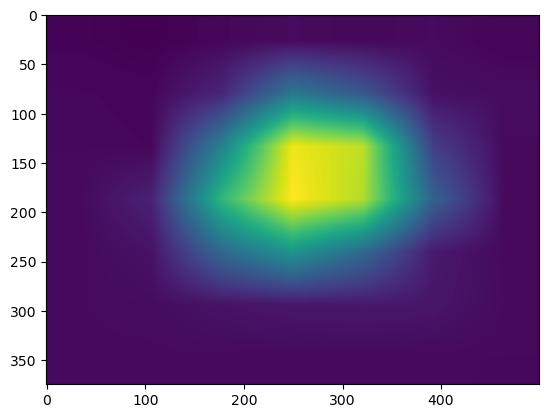

In [12]:
item = get_one(ds_test)

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [13]:
def visualize_cam_on_image(image, cam_image):
    beta = (1.0 - 0.5)
    merged_image = cv2.addWeighted(image, 0.5, cam_image, beta, 0.0)
    return merged_image

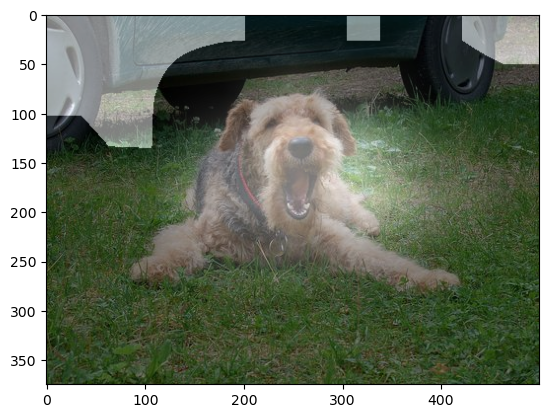

In [14]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

위의 이미지에서 모델이 강아지를 분류할 때 강아지의 얼굴 부분에 집중하고 있음을 알 수 있다.
그렇다면 같은 예시의 데이터에 대한 모델의 예측에 Grad-CAM을 적용하면 어떻게 나타날까?

In [15]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

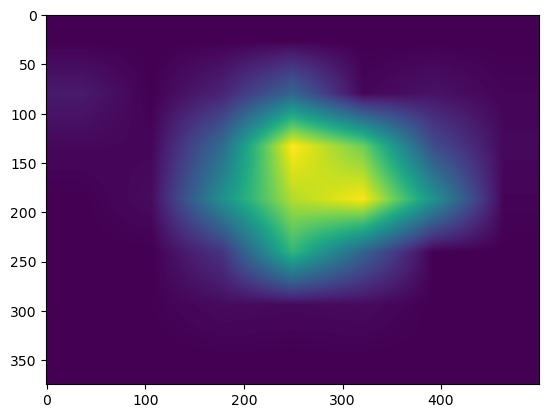

In [54]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

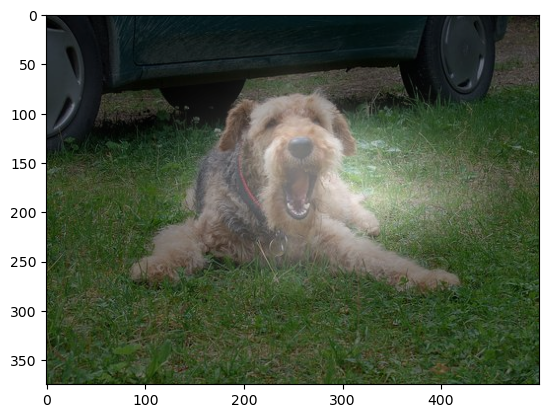

In [55]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

Grad-CAM을 원본 이미지와 합성해보았다. CAM과 유사하게 강아지의 모습에 집중하고 있는 것처럼 보인다.
이제 추가로 CAM과 Grad-CAM에 바운딩박스와 IoU를 계산하여 비교해보자.

In [73]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [74]:
rect = get_bbox(cam_image)
rect_grad = get_bbox(grad_cam_image)
rect, rect_grad

(array([[ 59, 173],
        [279, -23],
        [461, 177],
        [240, 375]], dtype=int64),
 array([[ 85, 237],
        [169,  11],
        [474, 124],
        [390, 351]], dtype=int64))

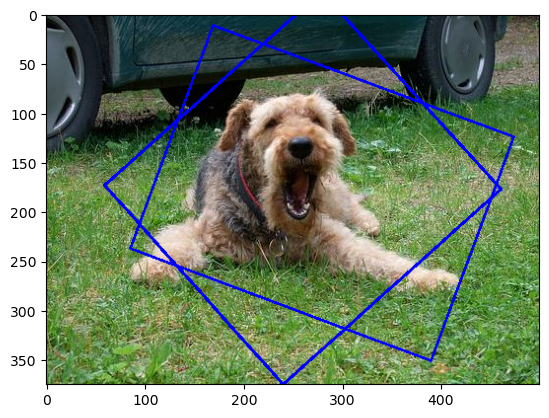

In [75]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image_grad = cv2.drawContours(image, [rect_grad], 0, (0,0,255), 2)
plt.imshow(image)
plt.imshow(image_grad)
plt.show()

CAM과 Grad-CAM에 바운딩박스를 적용해보았다. 이제 이를 바탕으로 IoU를 계산해보자.

In [24]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1]),
    ]
    return bbox

In [76]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_grad_bbox = rect_to_minmax(rect_grad, item['image'])
pred_bbox, pred_grad_bbox, item['objects']['bbox']

([-0.06133333333333333, 0.118, 1.0, 0.922],
 [0.029333333333333333, 0.17, 0.936, 0.948],
 array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32))

In [78]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    gt_bbox_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_bbox_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    
    iou = interArea / float(gt_bbox_area + pred_bbox_area - interArea)

    return iou

In [79]:
print('CAM IoU:', get_iou(pred_bbox, item['objects']['bbox'][0]),
      '\nGrad-CAM IoU:', get_iou(pred_grad_bbox, item['objects']['bbox'][0]))

CAM IoU: 0.44597987707813 
Grad-CAM IoU: 0.5370301416417129


IoU 계산 결과 Grad-CAM이 CAM보다 더 데이터의 바운딩박스와 겹치는 것을 확인할 수 있다.
이를 통해 Grad-CAM이 CAM보다 더 나은 성능을 보여주고 있다고 본다.

회고 : CAM과 Grad-CAM을 통해 모델이 어떻게 학습을 진행하는지 시각적으로 확인할 수 있는 방법을 알게 되었다. 이 실험에서 사용된 데이터셋과는 또 다른 데이터셋들과 다른 모델로 CAM 및 Grad-CAM을 적용해보면 어떨지 궁금하기도 하다.